## 导包 

In [1]:
import numpy as np
import pandas as pd
import jieba
import jieba.posseg as pseg
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import codecs
import os
import re
import matplotlib.pyplot as plt 
from gensim import corpora
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
 
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

## 定义手算版LDA模型函数（包含数据处理与TF-IDF算法） 

In [2]:
def chinese_word_cut(mytext,wordFlag="n,v,a,x"):
     jieba.load_userdict('prepare/用户自定义词典.txt');#加入自定义语料库
     words = pseg.cut(mytext)
     line_List=[]
     flag_List=wordFlag.split(",")
     for w in words:
         i=0;
         for flag in flag_List:#加入自定义语料库
            if(w.flag==flag_List[i] and not w.word.isnumeric() and w.word not in stopwordeu and len(re.findall('\s',w.word))==0):
                 line_List.append(w.word)
            i=i+1
     line=""
     for word in line_List:
          line+=word+" "
     return line
def prepare_data(content_list,attr1,attrmess,stopwords):
 #将数据格式进行转换[[数值，内容],[数值，内容],[数值，内容],[数值，内容]]
     df = pd.DataFrame(content_list, columns=[attr1,attrmess])
     #将数据格式进行转换
     df["內容切分"] = df[attrmess].astype(str).apply(chinese_word_cut)
     n_features = 3000000
     tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
     max_features=n_features,
     stop_words=stopwords,
      max_df = 0.5,
      min_df = 20)
     tf = tf_vectorizer.fit_transform(df['內容切分'])
     return df,tf, tf_vectorizer
def print_top_words2(model, feature_names, n_top_words):
     t=0;
     for topic_idx, topic in enumerate(model.components_):
         topicSum=np.sum(topic, axis=0)
         topic=topic/topicSum
         #topic 中存放的主题-词汇矩阵，格式是 ndarray
         print("Topic #%d:" % topic_idx)
    #tw_list.append("{name:Topic"+str(topic_idx)+","+"value:1,symbolSize:15
    # ,category:Topic"+str(topic_idx)+",draggable:false}");
     #argsort 返回从原始数值中，值小到大的索引值
         print(" | ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
         for i in topic.argsort()[:-n_top_words - 1:-1]:
                 t=t+1
         print(" | ".join([str(topic[i]) for i in topic.argsort()[:-n_top_words - 1:-1]]))
def load_stopword(path): 
     stopwords = open(path,'r',encoding='utf-8').read()
     stopwords = stopwords.split('\n')
     return stopwords
def train_one_step(n_components,tf,tf_vectorizer,n_top_words):
     lda = LatentDirichletAllocation(n_components, max_iter=200,
     learning_method='online',
     learning_offset=50.,
     random_state=0)
     lda.fit(tf)
     print(' n_components:%s'%n_components)
     tf_feature_names = tf_vectorizer.get_feature_names_out()
     print_top_words2(lda, tf_feature_names, n_top_words)
     doc_word = tf.toarray()
     doc_topic = lda.transform(tf)
     topic_word = lda.components_
     #计算困惑度
     print(u'困惑度：')
     print(lda.perplexity(tf,sub_sampling = False))
    # data = pyLDAvis.sklearn.prepare(lda,tf,tf_vectorizer)
    # pyLDAvis.show(data)
     return doc_word, doc_topic, topic_word, lda
import math
def savetopic_wordMat(topic_word,savePath):
     tw_list=topic_word.tolist()
     fw = open(savePath,'w')
     topicNum=0;
     for tw_line in tw_list:
         z=0;
         lineSum=sum(tw_line); 
         shangzhi=0;
         for j in tw_line:
             wordProbability=j/lineSum;
             if(z<len(tw_line)-1):
                fw.write(str(wordProbability)+" ")
             else:
                fw.write(str(wordProbability)+"\n")
             z=z+1
             temp=wordProbability*math.log(wordProbability)
             shangzhi=shangzhi+temp;
         print("Topic:"+str(topicNum)+"的信息熵是："+str(-shangzhi))
         topicNum=topicNum+1
def getMaxTopicFlag(doc_topic):
     new_dt=[]
     [rows, cols] = doc_topic.shape 
     for i in range(rows):
         maxflag=doc_topic[i].argsort()[-1]
         listTemp=doc_topic[i].tolist()
         listTemp.append(maxflag)
         new_dt.append(listTemp) 
     dtend=np.array(new_dt)
     return dtend
def saveDocTopicMat(attr1,attrmess,savePath,dtendMatrix):
     cols = ['Topic %s'%i for i in range(best_tops+1)]
     doc_topic = pd.DataFrame(dtendMatrix, columns=cols)
     new_df = pd.concat([df[[attr1,attrmess]], doc_topic], axis=1)
     print(new_df)
     new_df.to_excel(savePath, index=False)
     print(len(new_df))
def readCroups4FilePath(path):
    end_list=[]
    df=pd.read_csv(path)
    replacetext=[ # "本报[\S]+电",
                 # "（本报[\S]+电）",
                 "新华社[\S]+日电",
                 "人民网[\S]+日电",
                 "（(.*?)版权(.*?)）",
                 "服务邮箱：[\s\S]+",
                 "互联网新闻信息服务许可证(.*?)+",
                 "分享让更多人看到(.*?)+",
                 "《 人民日报 》（[\s\S]+",
                 "学习路上 时习之[\s\S]+",
                 "\r\n\|\r\n[\s\S]+",                                                                                                                                             
                 "（(.*?)记者(.*?)）"]
    t=0
    for index,row in df.iterrows():
        list1=[]
        t+=1
        for replace in replacetext:
              row[54]=re.sub(replace,"",str(row[54]))
        list1.append(t)
        list1.append(row[54])
        end_list.append(list1)
    return end_list

## 处理语料 

In [ ]:
attr1='标题'
attrmess='内容'
stopwordeu=load_stopword("prepare/stopwords.txt") 
#读取文件夹
end_list=readCroups4FilePath("data/中国能源网部分.csv");
print("文件数：" , len(end_list)) 
#最优主题个数
#组织语料
df, tf, tf_vectorizer=prepare_data(end_list,attr1,attrmess,stopwordeu)

with open("mi10_user_retweet_fc.txt" , 'w' , encoding='utf-8') as f:
    f.write("\n".join(list(df.loc[: , '內容切分'])))


# 去重（还未完成，参照去重文件，此处不影响后面运行） 

# LDA主题模型 

## 定义调包版LDA模型 

In [3]:
train = []
fp = codecs.open('mi10_user_retweet_fc.txt','r',encoding='utf-8')
for line in fp:
    if line != '':
        line = line.split()
        train.append([w for w in line])

dictionary = corpora.Dictionary(train)

corpus = [dictionary.doc2bow(text) for text in train]

lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=60)
# num_topics：主题数目
# passes：训练伦次
# num_words：每个主题下输出的term的数目

for topic in lda.print_topics(num_words = 15):
    termNumber = topic[0]
    print(topic[0], ':', sep='')
    listOfTerms = topic[1].split('+')
    for term in listOfTerms:
        listItems = term.split('*')
        print('  ', listItems[1], '(', listItems[0], ')', sep='')

C:\Users\86159\AppData\Local\Temp\ipykernel_22640\1968557871.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[54]=re.sub(replace,"",str(row[54]))
C:\Users\86159\AppData\Local\Temp\ipykernel_22640\1968557871.py:122: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  row[54]=re.sub(replace,"",str(row[54]))
C:\Users\86159\AppData\Local\Temp\ipykernel_22640\1968557871.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  list1.

文件数： 1000


Loading model cost 0.689 seconds.
Prefix dict has been built successfully.
D:\software\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['1a', '1b', '1c', '1d', '1e', '1f', '1g', '1h', '1i', '1o', '210', '2a', '2b', '2c', '2d', '2e', '2f', '2g', '2h', '2i', '2j', '310', '3a', '3b', '3c', '3d', '3e', '3f', '3g', '3h', '4a', '4b', '4c', '4d', '4e', '5a', '5b', '5d', '5e', '5f', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'iii', 'isn', 'lex', 'li', 'll', 'mon', 'ng昉', 'null', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn', 'zxfitl'] not in stop_words.
  warnings.warn(


0:
  "电网" (0.042)
  "公司" ( 0.025)
  "能源" ( 0.019)
  "电站" ( 0.014)
  "电力" ( 0.014)
  "新" ( 0.012)
  "线路" ( 0.011)
  "规模" ( 0.011)
  "项目" ( 0.011)
  "输电" ( 0.011)
  "智能" ( 0.010)
  "负荷" ( 0.010)
  "装机" ( 0.009)
  "充电" ( 0.009)
  "开工"( 0.009)
1:
  "量" (0.034)
  "煤" ( 0.032)
  "能源" ( 0.027)
  "信息" ( 0.021)
  "内容" ( 0.014)
  "用电" ( 0.013)
  "风电" ( 0.012)
  "电站" ( 0.011)
  "增量" ( 0.011)
  "资讯" ( 0.010)
  "太阳能" ( 0.010)
  "声明" ( 0.010)
  "免责" ( 0.009)
  "社会" ( 0.009)
  "观点"( 0.008)
2:
  "电站" (0.048)
  "互补" ( 0.028)
  "太阳能" ( 0.026)
  "项目" ( 0.026)
  "能源" ( 0.023)
  "潮光" ( 0.019)
  "智能" ( 0.015)
  "并网" ( 0.014)
  "公司" ( 0.012)
  "开发" ( 0.009)
  "全容量" ( 0.009)
  "原油" ( 0.009)
  "需求" ( 0.008)
  "储能" ( 0.008)
  "装机容量"( 0.007)
3:
  "电" (0.037)
  "洪涝" ( 0.028)
  "灾害" ( 0.026)
  "慰问" ( 0.023)
  "总统" ( 0.021)
  "项目" ( 0.018)
  "行业" ( 0.016)
  "国家" ( 0.011)
  "能源" ( 0.009)
  "人员伤亡" ( 0.009)
  "主席" ( 0.008)
  "天然气" ( 0.007)
  "能力" ( 0.007)
  "需求" ( 0.006)
  "新闻"( 0.006)
4:
  "电站" (0.034)
  "市场" ( 0.023

## 定义求最佳主题数的函数（两个中选一个） 

In [4]:
#计算困惑度
def perplexity(num_topics):
    ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30)
    print(ldamodel.print_topics(num_topics=num_topics, num_words=15))
    print(ldamodel.log_perplexity(corpus))
    return ldamodel.log_perplexity(corpus)
#计算coherence
def coherence(num_topics):
    ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30,random_state = 1)
    print(ldamodel.print_topics(num_topics=num_topics, num_words=10))
    ldacm = CoherenceModel(model=ldamodel, texts=train, dictionary=dictionary, coherence='c_v')
    print(ldacm.get_coherence())
    return ldacm.get_coherence()

## 绘制主题数——coherence曲线 

[(0, '0.015*"项目" + 0.014*"能源" + 0.014*"电站" + 0.012*"公司" + 0.011*"价格" + 0.009*"电" + 0.009*"电网" + 0.007*"行业" + 0.007*"用电" + 0.007*"煤"')]
0.18273317041945852
[(0, '0.022*"价格" + 0.020*"能源" + 0.013*"煤" + 0.012*"公司" + 0.011*"电" + 0.009*"量" + 0.008*"电站" + 0.008*"国家" + 0.007*"用电" + 0.006*"互补"'), (1, '0.030*"项目" + 0.020*"电站" + 0.014*"行业" + 0.011*"公司" + 0.011*"电网" + 0.009*"能源" + 0.007*"市场" + 0.007*"用电" + 0.006*"新" + 0.006*"电"')]
0.30783166991797695
[(0, '0.035*"价格" + 0.015*"能源" + 0.013*"电" + 0.013*"量" + 0.010*"信息" + 0.009*"洪涝" + 0.009*"煤" + 0.009*"灾害" + 0.009*"石油" + 0.009*"慰问"'), (1, '0.024*"行业" + 0.021*"电站" + 0.012*"市场" + 0.011*"公司" + 0.009*"变" + 0.008*"电" + 0.008*"需求" + 0.007*"线路" + 0.007*"用电" + 0.007*"电网"'), (2, '0.035*"项目" + 0.020*"电站" + 0.019*"能源" + 0.014*"公司" + 0.014*"电网" + 0.010*"新" + 0.009*"煤" + 0.008*"智能" + 0.007*"互补" + 0.007*"太阳能"')]
0.2683536004656371
[(0, '0.024*"煤" + 0.023*"价格" + 0.019*"量" + 0.016*"电" + 0.015*"能源" + 0.014*"信息" + 0.011*"原油" + 0.011*"洪涝" + 0.010*"灾害" + 0.010*"用电"'), (

0.31484321597698517
[(0, '0.047*"价格" + 0.035*"信息" + 0.029*"煤" + 0.024*"原油" + 0.022*"资讯" + 0.013*"指数" + 0.013*"保证" + 0.012*"免责" + 0.012*"声明" + 0.012*"内容"'), (1, '0.048*"电站" + 0.044*"蓄能" + 0.044*"抽水" + 0.018*"规模" + 0.016*"装机" + 0.013*"能源" + 0.011*"开工" + 0.011*"机组" + 0.011*"加快" + 0.008*"电网"'), (2, '0.085*"项目" + 0.038*"电站" + 0.026*"能源" + 0.018*"互补" + 0.013*"潮光" + 0.011*"智能" + 0.010*"分布式" + 0.010*"并网" + 0.010*"太阳能" + 0.009*"时间"'), (3, '0.032*"能源" + 0.023*"价格" + 0.017*"电站" + 0.015*"新" + 0.013*"上涨" + 0.012*"变" + 0.010*"产品" + 0.010*"系统" + 0.008*"风电" + 0.008*"需求"'), (4, '0.032*"公司" + 0.019*"智能" + 0.013*"需求" + 0.010*"用电" + 0.009*"电网" + 0.008*"领域" + 0.007*"市场" + 0.006*"平台" + 0.006*"电站" + 0.006*"拓展"'), (5, '0.064*"行业" + 0.031*"市场" + 0.023*"电" + 0.018*"内容" + 0.013*"从业者" + 0.012*"需求" + 0.011*"报告" + 0.010*"提供数据" + 0.010*"价格" + 0.010*"指标"'), (6, '0.046*"电网" + 0.024*"电" + 0.022*"能源" + 0.020*"新" + 0.020*"需求" + 0.013*"公司" + 0.009*"商" + 0.007*"行业" + 0.007*"配" + 0.007*"全球"'), (7, '0.025*"价格" + 0.020*"公司" +

0.4223400541127461
[(0, '0.054*"价格" + 0.040*"信息" + 0.030*"煤" + 0.027*"原油" + 0.026*"资讯" + 0.014*"指数" + 0.014*"观点" + 0.014*"上涨" + 0.014*"内容" + 0.013*"保证"'), (1, '0.067*"电站" + 0.050*"蓄能" + 0.050*"抽水" + 0.013*"充电" + 0.012*"机组" + 0.012*"加快" + 0.010*"电网" + 0.009*"规划" + 0.009*"能源" + 0.008*"市场"'), (2, '0.129*"项目" + 0.016*"分布式" + 0.015*"工程" + 0.015*"单位" + 0.014*"能源" + 0.014*"电站" + 0.013*"项目名称" + 0.013*"类型" + 0.013*"时间" + 0.012*"代码"'), (3, '0.032*"能源" + 0.017*"新" + 0.015*"电站" + 0.013*"价格" + 0.011*"系统" + 0.011*"风电" + 0.010*"太阳能" + 0.009*"用户" + 0.009*"利用" + 0.008*"行业"'), (4, '0.027*"公司" + 0.013*"能源" + 0.010*"用电" + 0.009*"价格" + 0.009*"需求" + 0.008*"高温" + 0.007*"电站" + 0.007*"成本" + 0.007*"工程" + 0.007*"网"'), (5, '0.088*"行业" + 0.041*"市场" + 0.034*"内容" + 0.029*"电" + 0.017*"从业者" + 0.016*"需求" + 0.014*"提供数据" + 0.013*"风险" + 0.013*"价格" + 0.013*"生命周期"'), (6, '0.040*"能源" + 0.033*"电网" + 0.020*"价格" + 0.020*"增长" + 0.019*"新" + 0.016*"公司" + 0.015*"需求" + 0.014*"上涨" + 0.012*"规模" + 0.012*"电"'), (7, '0.050*"价格" + 0.030*"

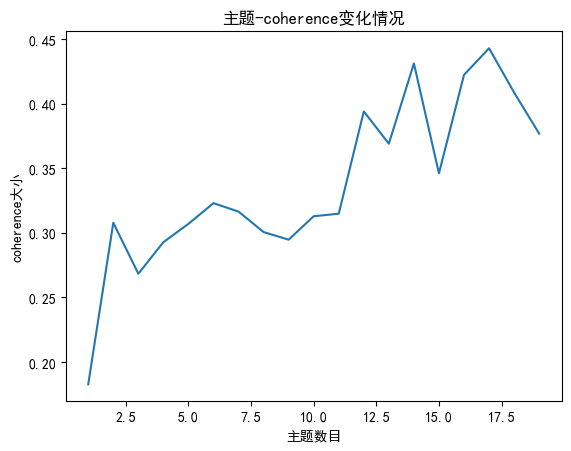

In [5]:
x = range(1,20)
# z = [perplexity(i) for i in x]  #如果想用困惑度就选这个
y = [coherence(i) for i in x]
plt.plot(x, y)
plt.xlabel('主题数目')
plt.ylabel('coherence大小')
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.title('主题-coherence变化情况')
plt.show()

## coherence最大处为最佳主题数 

In [6]:
#求coherence最大时的主题数
num_topics = y.index(max(y))
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics = num_topics, passes=100)
# num_topics：主题数目
# passes：训练伦次
# num_words：每个主题下输出的term的数目

# 调包法求最佳主题数下的LDA模型
for topic in lda.print_topics(num_words = 15):
    termNumber = topic[0]
    print(topic[0], ':', sep='')
    listOfTerms = topic[1].split('+')
    for term in listOfTerms:
        listItems = term.split('*')
        print('  ', listItems[1], '(', listItems[0], ')', sep='')

0:
  "电站" (0.066)
  "能源" ( 0.056)
  "量" ( 0.030)
  "互补" ( 0.023)
  "抽水" ( 0.021)
  "蓄能" ( 0.021)
  "太阳能" ( 0.019)
  "项目" ( 0.018)
  "潮光" ( 0.016)
  "风电" ( 0.012)
  "智能" ( 0.012)
  "新" ( 0.012)
  "规划" ( 0.012)
  "用电" ( 0.011)
  "增量"( 0.011)
1:
  "价格" (0.069)
  "能源" ( 0.054)
  "新" ( 0.032)
  "上涨" ( 0.031)
  "原油" ( 0.019)
  "石油" ( 0.014)
  "增长" ( 0.012)
  "月份" ( 0.011)
  "规模" ( 0.011)
  "成本" ( 0.010)
  "油价" ( 0.009)
  "国际" ( 0.008)
  "商品" ( 0.008)
  "推动" ( 0.007)
  "装机"( 0.007)
2:
  "遇难者" (0.031)
  "灾害" ( 0.018)
  "人员伤亡" ( 0.018)
  "洪涝" ( 0.018)
  "慰问" ( 0.017)
  "原油" ( 0.016)
  "谨向" ( 0.016)
  "深切" ( 0.016)
  "哀悼" ( 0.016)
  "财产损失" ( 0.016)
  "惊悉" ( 0.016)
  "发生" ( 0.016)
  "行业" ( 0.015)
  "祝愿" ( 0.015)
  "诚挚"( 0.015)
3:
  "信息" (0.044)
  "资讯" ( 0.025)
  "内容" ( 0.017)
  "保证" ( 0.016)
  "免责" ( 0.016)
  "观点" ( 0.016)
  "声明" ( 0.016)
  "天然气" ( 0.016)
  "煤" ( 0.016)
  "公司" ( 0.015)
  "变更" ( 0.015)
  "准确" ( 0.015)
  "客观" ( 0.015)
  "力求" ( 0.015)
  "价格"( 0.015)
4:
  "电" (0.043)
  "市场" ( 0.033)


## 绘制LDA图像 

In [7]:
import pyLDAvis.gensim

'''插入之前的代码片段'''

d=pyLDAvis.gensim.prepare(lda, corpus, dictionary)

'''
lda: 计算好的话题模型

corpus: 文档词频矩阵

dictionary: 词语空间
'''
pyLDAvis.save_html(d, 'lda_visualization.html')
pyLDAvis.display(d) #展示在notebook的output cell中

## 使用手动TF-IDF法求最佳主题数下的LDA 

In [8]:
if __name__ == '__main__':
     #文件名称
     # fileName="law"
     attr1='标题'
     attrmess='内容'
     stopwordeu=load_stopword("prepare/stopwords.txt") 
     #读取文件夹
     end_list=readCroups4FilePath("data/中国能源网部分.csv");
     print("文件数：" , len(end_list)) 
     #最优主题个数
     #组织语料
     df, tf, tf_vectorizer=prepare_data(end_list,attr1,attrmess,stopwordeu)
     #训练
     best_tops=num_topics
     doc_word,doc_topic, topic_word, lda_model = train_one_step(best_tops,tf,tf_vectorizer,n_top_words=20)
     dtendMatrix=getMaxTopicFlag(doc_topic)
     savetopic_wordMat(topic_word,'result/'+'doc_topic'+str(best_tops)+'temptw.txt')
     saveDocTopicMat(attr1,attrmess,'result/'+'doc_topic'+str(best_tops)+'tempdt.xlsx',dtendMatrix)

C:\Users\86159\AppData\Local\Temp\ipykernel_22640\1968557871.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[54]=re.sub(replace,"",str(row[54]))
C:\Users\86159\AppData\Local\Temp\ipykernel_22640\1968557871.py:122: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  row[54]=re.sub(replace,"",str(row[54]))
C:\Users\86159\AppData\Local\Temp\ipykernel_22640\1968557871.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  list1.

文件数： 1000


D:\software\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['1a', '1b', '1c', '1d', '1e', '1f', '1g', '1h', '1i', '1o', '210', '2a', '2b', '2c', '2d', '2e', '2f', '2g', '2h', '2i', '2j', '310', '3a', '3b', '3c', '3d', '3e', '3f', '3g', '3h', '4a', '4b', '4c', '4d', '4e', '5a', '5b', '5d', '5e', '5f', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'iii', 'isn', 'lex', 'li', 'll', 'mon', 'ng昉', 'null', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn', 'zxfitl'] not in stop_words.
  warnings.warn(


 n_components:16
Topic #0:
能源 | 推动 | 计划 | 情况 | 清洁 | 开工 | 水电 | 高效 | 增长 | 支持 | 水平 | 提出 | 利用 | 电力 | 领域 | 相关 | 提高 | 提升 | 能力 | 全球
0.389140227016092 | 0.09218038264673391 | 0.06664305539833629 | 0.05540300902049388 | 0.050923457766667624 | 0.04869710690675002 | 0.03759931221165526 | 0.026953910947471772 | 0.025244814003366402 | 0.02325836021149821 | 0.022623158075204465 | 0.02162960213726813 | 0.020628611216967595 | 0.01874543306334936 | 0.0169443553762358 | 0.016401210931106736 | 0.015451134130078896 | 0.010258692966951814 | 0.009988618587469343 | 0.006619950927340408
Topic #1:
用电 | 线路 | 运行 | 负荷 | 保障 | 电网 | 电力 | 确保 | 现场 | 需求 | 提升 | 能力 | 提供 | 提高 | 计划 | 稳定 | 情况 | 中心 | 模式 | 部门
0.21515523987734347 | 0.09827524304147994 | 0.08164044889874213 | 0.05596567236523814 | 0.053631803014037284 | 0.052236869480563525 | 0.05036483478929915 | 0.03580643176228997 | 0.03445617249273247 | 0.03442227096865398 | 0.027207060327068686 | 0.023552070200358398 | 0.02316139775931287 | 0.020622321179653687 | 0.0204052

1000


## 寻找目标主题下的语料 

In [9]:
#文档—主题矩阵
df = pd.DataFrame(dtendMatrix)
df["相关度"] = df[7] #此处根据需求自定义
df = df.sort_values(by = "相关度" , ascending = False) #按目标主题频率从大到小排列
# 求出指定范围下的语料
df_topic = df[:200]
df_topic

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,相关度
215,0.002155,0.002155,0.002155,0.002155,0.002155,0.002155,0.002155,0.967672,0.002155,0.002155,0.002155,0.002155,0.002155,0.002155,0.002155,0.002155,7.0,0.967672
256,0.002315,0.002315,0.002315,0.002315,0.002315,0.002315,0.002315,0.965278,0.002315,0.002315,0.002315,0.002315,0.002315,0.002315,0.002315,0.002315,7.0,0.965278
216,0.003125,0.003125,0.003125,0.003125,0.003125,0.003125,0.003125,0.953125,0.003125,0.003125,0.003125,0.003125,0.003125,0.003125,0.003125,0.003125,7.0,0.953125
283,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.937500,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,7.0,0.937500
239,0.004808,0.004808,0.004808,0.004808,0.004808,0.004808,0.004808,0.927885,0.004808,0.004808,0.004808,0.004808,0.004808,0.004808,0.004808,0.004808,7.0,0.927885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,15.0,0.062500
170,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,15.0,0.062500
467,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,15.0,0.062500
162,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,15.0,0.062500
